## Final Project Day 1: Logistic Regression Model for the Product Safety Dataset

For the final project, build a Logistic Regression model to predict the __human_tag__ field of the dataset. You will submit your predictions to the Leaderboard competition here: https://mlu.corp.amazon.com/contests/redirect/53

You can use the __MLA-NLP-DAY1-LOGISTIC-REGR-NB__ notebook as yor starting code. Train and test your model with the corresponding datasets provided here. We are using F1 score to rank submissions. Sklearn provides the [__f1_score():__](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) function if you want to see how your model works on your training or validation set.

You can follow these steps:
1. Read training-test data (Given)
2. Train a Logistic Regression model (Implement)
3. Make predictions on your test dataset (Given)
4. Write your test predictions to a CSV file (Given)

In [1]:
# Upgrade dependencies
! pip install -r ../../requirements.txt

In [3]:
import boto3
import os
import numpy as np
import pandas as pd
import nltk, re
import time
import torch
import torch.nn as nn

from os import path
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.nn import BCELoss
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer
from nltk.tokenize import word_tokenize

nltk.download("punkt")
nltk.download("stopwords")

%matplotlib inline
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /home/ec2-user/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /home/ec2-user/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## 1. Reading the dataset (Given)

We will use the __pandas__ library to read our dataset. Let's first run the following credential cell and then download the files.

#### __Training data:__

In [4]:
train_df = pd.read_csv('../../data/final_project/training.csv', encoding='utf-8', header=0)
train_df.head()

,ID,doc_id,text,date,star_rating,title,human_tag
0,47490,15808037321,"I ordered a sample of the Dietspotlight Burn, ...",6/25/2018 17:51,1,DO NOT BUY!,0
1,16127,16042300811,This coffee tasts terrible as if it got burnt ...,2/8/2018 15:59,2,Coffee not good,0
2,51499,16246716471,I've been buying lightly salted Planters cashe...,3/22/2018 17:53,2,"Poor Quality - Burnt, Shriveled Nuts With Blac...",0
3,36725,14460351031,This product is great in so many ways. It goes...,12/7/2017 8:49,4,"Very lovey product, good sunscreen, but strong...",0
4,49041,15509997211,"My skin did not agree with this product, it wo...",3/21/2018 13:51,1,Not for everyone. Reactions can be harsh.,1


#### __Test data:__

In [5]:
test_df = pd.read_csv('../../data/final_project/test.csv', encoding='utf-8', header=0)
test_df.head()

,ID,doc_id,text,date,star_rating,title
0,62199,15449606311,"Quality of material is great, however, the bac...",3/7/2018 19:47,3,great backpack with strange fit
1,76123,15307152511,The product was okay but wasn't refined campho...,43135.875,2,Not refined
2,78742,12762748321,I normally read the reviews before buying some...,42997.37708,1,"Doesnt work, wouldnt recommend"
3,64010,15936405041,These pads are completely worthless. The light...,43313.25417,1,The lighter colored side of the pads smells li...
4,17058,13596875291,The saw works great but the blade oiler does n...,12/5/2017 20:17,2,The saw works great but the blade oiler does n...


## 2. Train a Logistic Regression Model (Implement)
Here, we apply pre-processing and vectorization operations and train the model. You can use the __MLA-NLP-DAY1-LOGISTIC-REGR-NB__ notebook as yor starting code. We are using the F1 score in the competition. In sklearn, you can use the [__f1_score():__](https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html) function to see your F1 score on your training or validation set.

### 2.1 Split Training data into training and validation and process text field (given)
Here, we give you the code to split your dataset into training and validation sets and then process their text fields. You can start with this. Later, you can experiment with some changes here such as changing the size of your bag of words features (max_len) or trying different preprocessing operations.

In [6]:
# Let's first process the text data

print("Fixing missing values...")
# Fixing the missing values
train_df["text"].fillna("", inplace=True)

print("Splitting data into training and validation...")
X_train, X_val, y_train, y_val = train_test_split(
    train_df[["text"]],
    train_df["human_tag"].values,
    test_size=0.10,
    shuffle=True,
    random_state=324,
)

# Stop words removal and stemming
# Let's get a list of stop words from the NLTK library
stop = stopwords.words("english")

# These words are important for our problem. We don't want to remove them.
excluding = [
    "against",
    "not",
    "don",
    "don't",
    "ain",
    "aren",
    "aren't",
    "couldn",
    "couldn't",
    "didn",
    "didn't",
    "doesn",
    "doesn't",
    "hadn",
    "hadn't",
    "hasn",
    "hasn't",
    "haven",
    "haven't",
    "isn",
    "isn't",
    "mightn",
    "mightn't",
    "mustn",
    "mustn't",
    "needn",
    "needn't",
    "shouldn",
    "shouldn't",
    "wasn",
    "wasn't",
    "weren",
    "weren't",
    "won",
    "won't",
    "wouldn",
    "wouldn't",
]

# New stop word list
stop_words = [word for word in stop if word not in excluding]

snow = SnowballStemmer("english")

def process_text(texts):
    final_text_list = []
    for sent in texts:

        # Check if the sentence is a missing value
        if isinstance(sent, str) == False:
            sent = ""

        filtered_sentence = []
        
        # Lowercase
        sent = sent.lower()
        # Remove leading/trailing whitespace
        sent = sent.strip()
        # Remove extra space and tabs
        sent = re.sub("\s+", " ", sent)
        # Remove HTML tags/markups:
        sent = re.compile("<.*?>").sub("", sent)

        for w in word_tokenize(sent):
            # We are applying some custom filtering here, feel free to try different things
            # Check if it is not numeric and its length>2 and not in stop words
            if (not w.isnumeric()) and (len(w) > 2) and (w not in stop_words):
                # Stem and add to filtered list
                filtered_sentence.append(snow.stem(w))
        final_string = " ".join(filtered_sentence)  # final string of cleaned words

        final_text_list.append(final_string)

    return final_text_list

print("Processing the text fields...")
X_train["text"] = process_text(X_train["text"].tolist())
X_val["text"] = process_text(X_val["text"].tolist())

# Use TD-IDF to vectorize to vectors of len 750.
tf_idf_vectorizer = TfidfVectorizer(max_features=750)

# Fit the vectorizer to training data
# Don't use the fit() on validation or test datasets
tf_idf_vectorizer.fit(X_train["text"].values)

print("Transforming the text fields (Bag of Words)...")
# Transform text fields
X_train = tf_idf_vectorizer.transform(X_train["text"].values).toarray()
X_val = tf_idf_vectorizer.transform(X_val["text"].values).toarray()

print("Shapes of features: Training and Validation")
print(X_train.shape, X_val.shape)

Fixing missing values...
Splitting data into training and validation...
Processing the text fields...
Transforming the text fields (Bag of Words)...
Shapes of features: Training and Validation
(56820, 750) (6314, 750)


### 2.2 Train your neural network (implement)
Train your neural network using the training data (X_train) and validation data (X_val) from above. Don't forget to create the data loaders etc that you need here. You can simply use the code from your logistic regression notebook (__MLA-NLP-DAY1-LOGISTIC-REGR-NB__) and try different hyperparameters such batch size and learning rate.

In [6]:
# Implement this
# How many samples to use for each weight update
batch_size = 16
# Total number of iterations
# One epoch is one pass over all data in the training set
epochs = 25  # was 15
# Learning rate
lr = 0.005   # was 0.01

# Run the training in the GPU if supported by our instance, else in the CPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('device = ', device)

# Let's build our single layer network (logistic regression here)
net = nn.Sequential(
    nn.Linear(in_features=750, # matches the size of vectorizer: 750
              out_features=1), 
    nn.Sigmoid()
)
net.to(device)

# Initialize the network
def init_weights(m):
    if type(m) == nn.Linear:
        nn.init.normal_(m.weight, std=1)
        nn.init.zeros_(m.bias)
net.apply(init_weights)

# Define the loss. For binary classification the appropriate choice is Binary Cross Entropy.
# As we used sigmoid in the last layer, we use `nn.BCELoss`.
# Otherwise we could have made use of `nn.BCEWithLogitsLoss`.
loss = BCELoss(reduction="none")

# Define the optimizer, SGD (Stochastic Gradient Descent) with learning rate
optimizer = torch.optim.SGD(net.parameters(), lr=lr)

# Use PyTorch DataLoaders to load the data in batches
train_dataset = TensorDataset(
    torch.tensor(X_train, dtype=torch.float32),
    torch.tensor(y_train, dtype=torch.float32),
)
train_loader = DataLoader(train_dataset, batch_size=batch_size)

# Move validation dataset on CPU/GPU device
X_val = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val = torch.tensor(y_val, dtype=torch.float32).to(device)

device =  cuda:0


In [7]:
# Lists to store the losses as the training progresses
train_losses = []
val_losses = []

# Loop over epochs
for epoch in range(epochs):
    start = time.time()
    training_loss = 0
    # Build a training loop to train the network
    for data, target in train_loader:
        # zero the parameter gradients
        optimizer.zero_grad()

        data = data.to(device)
        target = target.to(device).view(-1, 1)

        # Forward pass - compute the predictions of the NN on the batch
        output = net(data)  
        # Compute the loss and sum (error between the net's predictions and the actual labels)
        L = loss(output, target).sum()
        training_loss += L.item() 
        # Calculate gradients
        L.backward()  
        # Update weights with gradient descent
        optimizer.step()  

    # Get validation predictions
    val_predictions = net(X_val)
    # Calculate the validation loss
    val_loss = torch.sum(loss(val_predictions, y_val.view(-1, 1))).item()

    # Take the average losses
    training_loss = training_loss / len(y_train)
    val_loss = val_loss / len(y_val)

    train_losses.append(training_loss)
    val_losses.append(val_loss)

    end = time.time()
    print(
        f"Epoch {epoch}. Train_loss {training_loss}, Validation_loss {val_loss}, Seconds {end-start}"
    )

Epoch 0. Train_loss 0.47729519103791085, Validation_loss 0.4483526191796009, Seconds 3.5095369815826416
Epoch 1. Train_loss 0.42878075858229947, Validation_loss 0.4122653558807808, Seconds 3.5463614463806152
Epoch 2. Train_loss 0.39879874630068357, Validation_loss 0.3882956880914436, Seconds 3.4812722206115723
Epoch 3. Train_loss 0.3783273790743686, Validation_loss 0.37178665465631927, Seconds 3.5706398487091064
Epoch 4. Train_loss 0.36383262180140724, Validation_loss 0.35996559295315966, Seconds 3.5832924842834473
Epoch 5. Train_loss 0.35318136835173797, Validation_loss 0.3511853464275816, Seconds 3.5890254974365234
Epoch 6. Train_loss 0.34507945760250597, Validation_loss 0.34444723531042126, Seconds 3.5329654216766357
Epoch 7. Train_loss 0.338725952793074, Validation_loss 0.3391281094096452, Seconds 3.6193666458129883
Epoch 8. Train_loss 0.33361156753401067, Validation_loss 0.33482707388838295, Seconds 3.5903515815734863
Epoch 9. Train_loss 0.32940262581042445, Validation_loss 0.3312

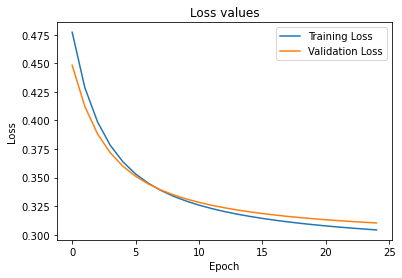

In [8]:
plt.plot(train_losses, label="Training Loss")
plt.plot(val_losses, label="Validation Loss")
plt.title("Loss values")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

## 3. Make predictions on your test dataset (given)

Let's make predictions on the test dataset. We apply the same processes as we did earlier on the train-val datasets. 

We do the following. You don't need to change this part.
1. Fill-in missing values: -> fillna()
2. Clean and normalize text: -> process_text()
3. Vectorize with your tf_idf_vectorizer. Use the transform() function: -> tf_idf_vectorizer.transform().toarray()
4. Convert to Torch tensor: -> torch.tensor(output_of_transform, dtype=torch.float32).to(device)
5. Get predictions: -> net(torch_test_data)
6. Round up to 1 or down to 0: -> np.rint(test_predictions.detach().cpu().numpy())

You will save your predictions (__test_predictions__ variable) to a CSV file in section 4.

In [9]:
# Fixing the missing values
print("Fixing the missing values...")
test_df["text"].fillna("", inplace=True)
print("Processing the text field...")
test_df["text"] = process_text(test_df["text"].tolist())
print("Transforming the text field...")
X_test = tf_idf_vectorizer.transform(test_df["text"].values).toarray()
print("Converting it to Torch tensor...")
X_test = torch.tensor(X_test, dtype=torch.float32).to(device)
print("Making the test predictions...")
test_predictions = net(X_test)
test_predictions = np.rint(test_predictions.detach().cpu().numpy())
test_predictions = np.squeeze(test_predictions)
print("Here is the test predictions:", test_predictions)

Fixing the missing values...
Processing the text field...
Transforming the text field...
Converting it to Torch tensor...
Making the test predictions...
Here is the test predictions: [0. 0. 0. ... 0. 0. 0.]


## 4. Write your predictions to a CSV file and submit to the contest
You can use the following code to write your test predictions to a CSV file. Then upload your file to https://mlu.corp.amazon.com/contests/redirect/53 Look at __"data/final_project"__ folder to find your file: project_day1_result.csv

In [10]:
import pandas as pd
 
result_df = pd.DataFrame()
result_df["ID"] = test_df["ID"]
result_df["human_tag"] = test_predictions
 
#result_df.to_csv("../../data/final_project/project_day1_result.csv", encoding='utf-8', index=False)
result_df.to_csv("./project_day1_result.csv", encoding='utf-8', index=False)